# **Data Collection**

## Objectives

* Download data from Kaggle.com and perform an initial EDA.

## Inputs

* unclean_smartwatch_health_data.csv

## Outputs

* ydata-profiling EDA

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [ ]:
import os
current_dir = os.getcwd()
current_dir

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

Confirm the new current directory

In [ ]:
current_dir = os.getcwd()
current_dir

Include data path

In [ ]:
DataUntouched = "inputs/smartwatch_health_data_untouched"

In [ ]:
import pandas as pd
data = pd.read_csv(DataUntouched + "/unclean_smartwatch_health_data.csv")
df = pd.DataFrame(data)
print(df.head())

# Change version variable to store outputs in different folder
version = "v1"

OutputFolder = f"outputs/{version}/"
if "outputs" in os.listdir(current_dir):
    if version not in os.listdir(current_dir + "/outputs"):
        os.mkdir(OutputFolder)
else:
    os.makedirs(OutputFolder)

# Clean Data

Cleaning will be performed, as from the initial EDA we can see we have 1551 missing cells across all features, Hypothesis 1 doesnt have a target variable as we are looking to perform unsupervised clustering to group. Hypothesis 2's target is Stress Levels and hypothesis 3's is Step Count.

Now we will drop the User ID feature and fix the data types, perform imputation of categoric variables first, perform transformations on numerical data to improve its normality, skewness and kurtosis.
Also try and imporove normality and skewness on the columns that require it.

---

Drop User ID from a copy of the original dataset

In [ ]:
df_todrop = df.copy()
df_dropped = df_todrop.drop("User ID", axis=1)

In [ ]:
print(df_dropped.columns)
df_dropped.head()
df_dropped.isnull().sum()

Now lets check the initial distribution and general analysis of the one true categorical column Acitivity Level

In [ ]:
df_category_test = df_dropped["Activity Level"]
df_category_test.unique()

We note the categorical column has 5 unique classes, not including the NaN value

Note that encoding of this categorical column seems likely. The distributions of each class in Actitivity level are well balanced. There should be low bias with this metric


In [ ]:
df_category_test.value_counts()

Lets take a closer look at the other two data type objects that should be a float64 and int

Next we note that column Sleep Duration (hours) has some cells that include the string "ERROR", we must replace or drop this to impute and change the variables datatype. We could replace this value with NaN, and then impute with the median

In [ ]:
df_dropped["Sleep Duration (hours)"].value_counts()

We also note that column Stress Level includes numbers 1 to 10, and one variable named "Very High", we may replace very high with 11 or a custom value based on dataset knowledge

In [ ]:
df_dropped["Stress Level"].value_counts()

Lets go ahead replace the "Very High" class in the Stress Level column with 11

In [ ]:
df_preprocess = df_dropped.copy()

df_preprocess["Stress Level"] = df_preprocess["Stress Level"].replace("Very High", 11)
df_preprocess["Stress Level"].value_counts()

Lets replace ERROR cells in the Sleep Duration column with NaN. But Instead of replacing all non-numeric values with NaN we can just use the coerce parameter in pd.to_numeric below, to change any non-numeric values into NaN.

Now lets attempt changing the dtype on the two columns Sleep Duration and Stress Level

In [15]:
# Convert the columns to numeric data types, handling non-numeric values
df_preprocess["Sleep Duration (hours)"] = pd.to_numeric(df_preprocess["Sleep Duration (hours)"], errors='coerce')
df_preprocess["Stress Level"] = pd.to_numeric(df_preprocess["Stress Level"], errors='coerce')

# Check the data types of the columns after conversion
print("Data types after conversion to numeric:")
print(df_preprocess.dtypes)

Data types after conversion to numeric:
Heart Rate (BPM)          float64
Blood Oxygen Level (%)    float64
Step Count                float64
Sleep Duration (hours)    float64
Activity Level             object
Stress Level              float64
dtype: object


Now impute the all the columns with the median, as most columns are not normaly distributed yet.

In [ ]:
from feature_engine.imputation import MeanMedianImputer

# Define the pipeline with MeanMedianImputer
median_imputer = MeanMedianImputer(imputation_method='median')

# Fit and transform the data using the pipeline
df_processed = median_imputer.fit_transform(df_preprocess)

Now lets attempt changing the dtype on the Stress Level to int64 as to_numeric made it a float.

In [24]:
# Set explicit data types
df_processed["Stress Level"] = df_processed["Stress Level"].astype("int64")

# Check the data types of the columns again
print("Data types after setting explicit types:")
print(df_processed.dtypes)
df_processed.head()

Data types after setting explicit types:
Heart Rate (BPM)          float64
Blood Oxygen Level (%)    float64
Step Count                float64
Sleep Duration (hours)    float64
Activity Level             object
Stress Level                int64
dtype: object


,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,58.939776,98.809650,5450.390578,7.167236,Highly Active,1
1,75.220601,98.532195,727.601610,6.538239,Highly_Active,5
2,247.803052,97.052954,2826.521994,6.503308,Highly Active,5
3,40.000000,96.894213,13797.338044,7.367790,Actve,3
4,61.950165,98.583797,15679.067648,6.503308,Highly_Active,6


In [33]:
print(df_processed.columns)

# Check skewness and kurtosis after transformation and imputation
for col in ['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count',
       'Sleep Duration (hours)', 'Stress Level']:
    print("Skewness and Kurtosis before type change and imputation:")
    print(f"{col} | Skewness: {df_preprocess[col].skew()} | Kurtosis: {df_preprocess[col].kurtosis()}")
    print("\n")
    print("Skewness and Kurtosis after type change and imputation:")
    print(f"{col} | Skewness: {df_processed[col].skew()} | Kurtosis: {df_processed[col].kurtosis()}")
    print("\n")



Index(['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count',
       'Sleep Duration (hours)', 'Activity Level', 'Stress Level'],
      dtype='object')
Skewness and Kurtosis before type change and imputation:
Heart Rate (BPM) | Skewness: 3.8886812373677984 | Kurtosis: 35.57465239876149


Skewness and Kurtosis after type change and imputation:
Heart Rate (BPM) | Skewness: 3.973562985040958 | Kurtosis: 37.202734787667


Skewness and Kurtosis before type change and imputation:
Blood Oxygen Level (%) | Skewness: -0.5715440023861363 | Kurtosis: -0.30998659609027834


Skewness and Kurtosis after type change and imputation:
Blood Oxygen Level (%) | Skewness: -0.5889504945433629 | Kurtosis: -0.22140785164571275


Skewness and Kurtosis before type change and imputation:
Step Count | Skewness: 1.97201457915679 | Kurtosis: 5.961355681473938


Skewness and Kurtosis after type change and imputation:
Step Count | Skewness: 1.987981880514301 | Kurtosis: 6.059740238843574


Skewness and Kurtosis 

Skewness and Kurtosis definatley needs improvement, transformers will definatley be used on the data in the feature engineering step to improve overall normality.

Lets now identify if we have any outliers in the data, and think what we want to do with them, if they exist.

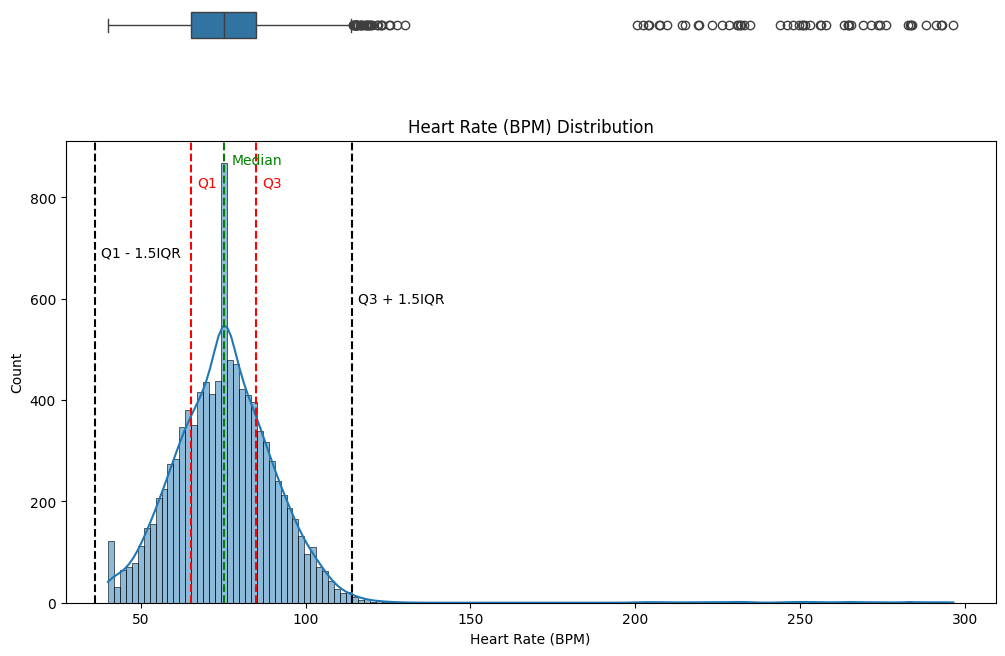

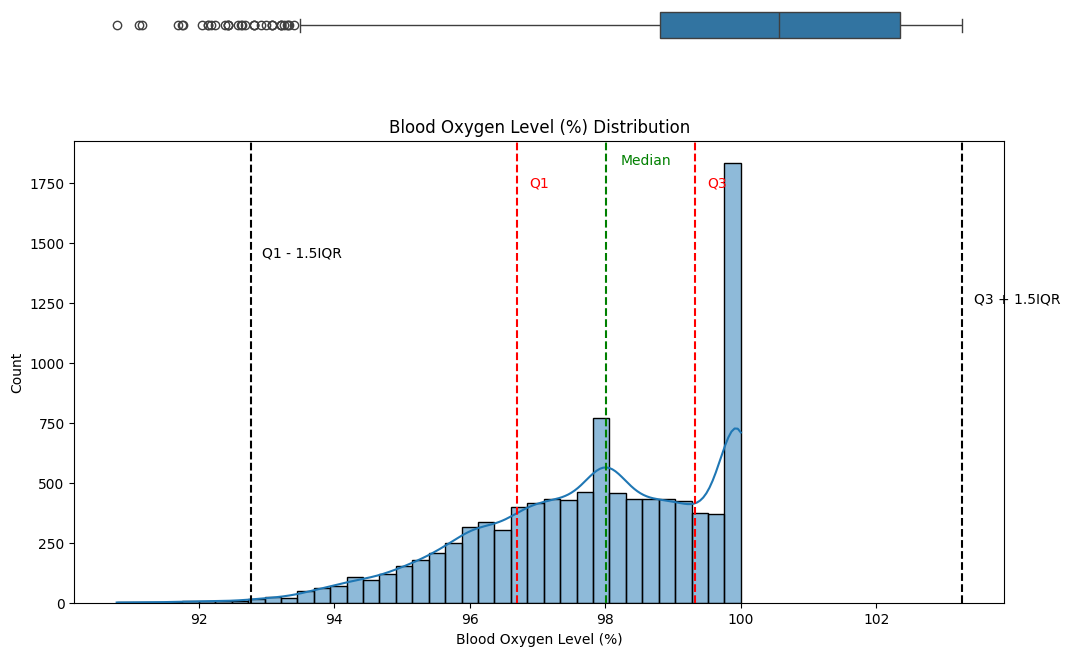

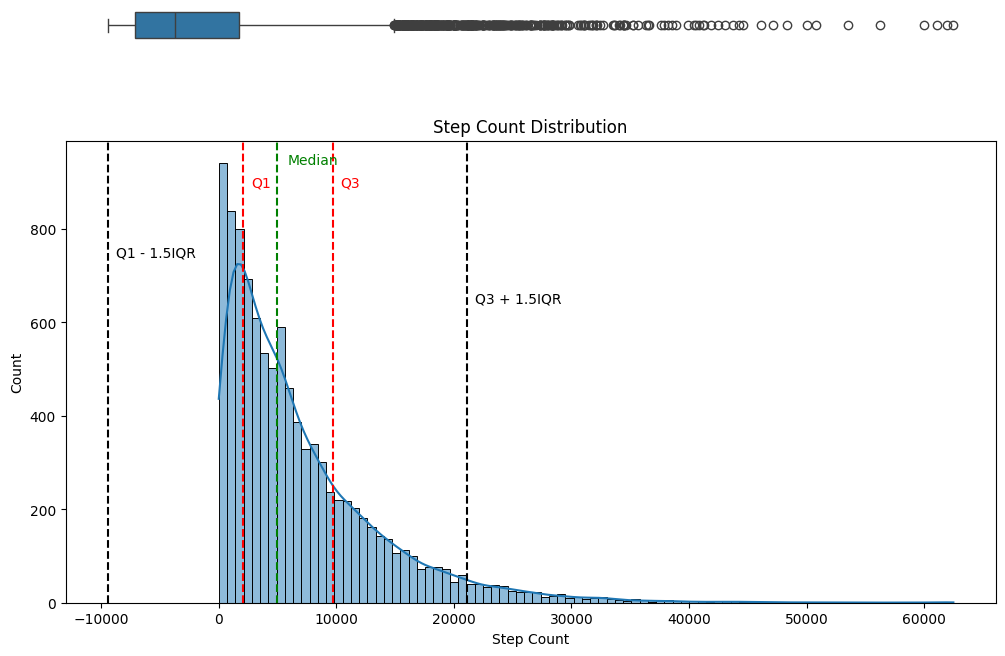

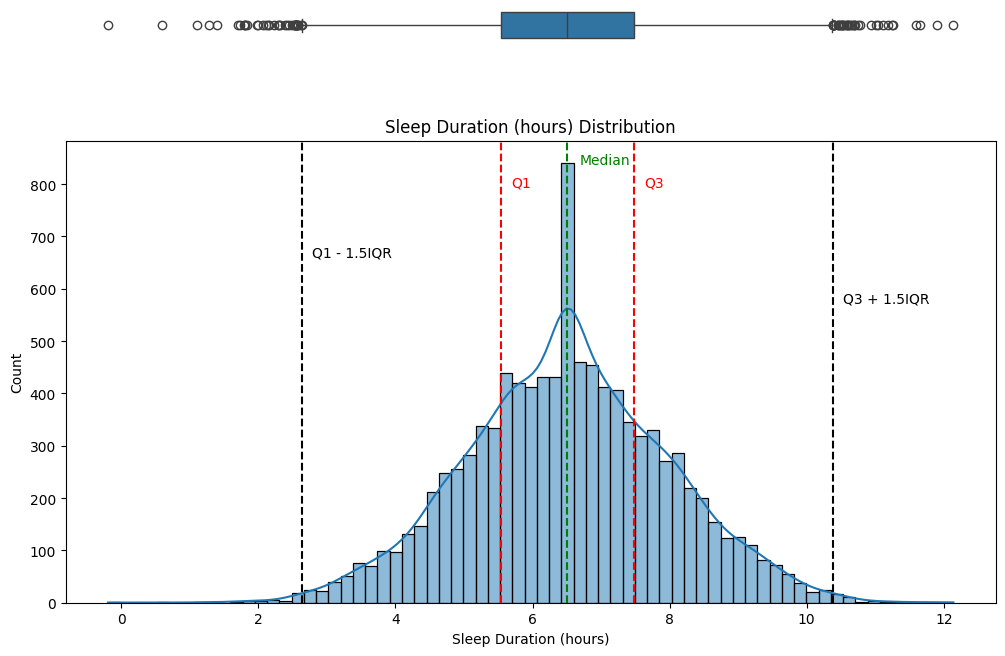

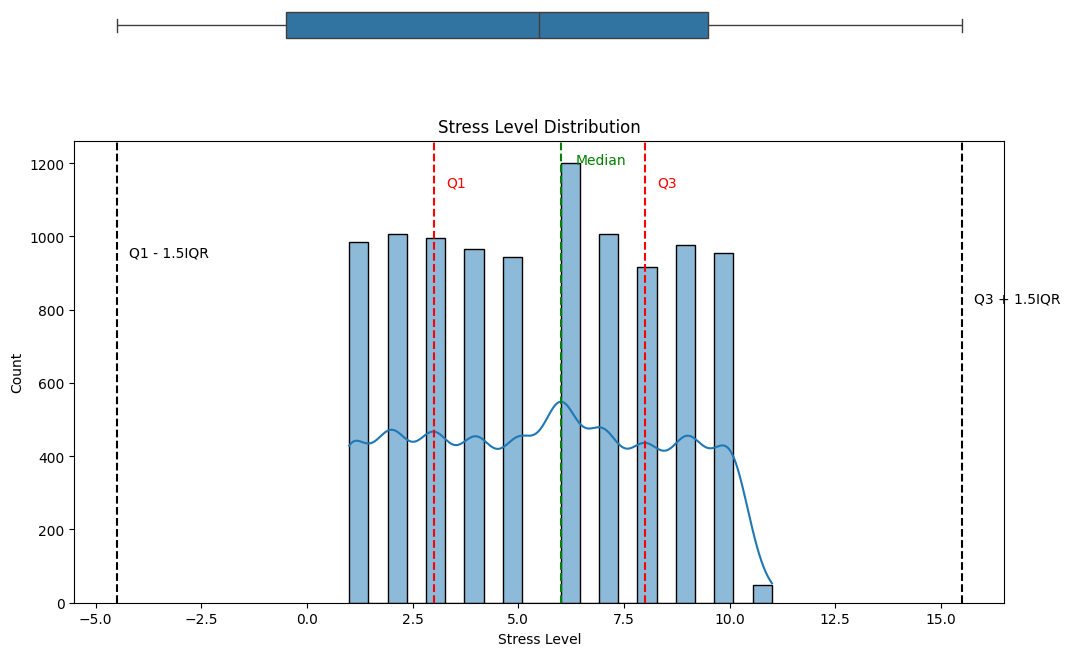

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df = df_processed

OutlierViz = OutputFolder + "outlier_viz/"
if "outlier_viz" not in os.listdir(OutputFolder):
    os.mkdir(OutlierViz)

for col in df.select_dtypes(include='number').columns:
    fig, axes = plt.subplots(figsize=(12, 6))
    plt.title(f"{col} Distribution")
    sns.histplot(data=df, x=col, kde=True, ax=axes)

    # Add median line
    plt.axvline(df[col].median(), color='g', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].median() + df[col].std()/8, y=axes.get_ylim()[1] * 0.95, s='Median', fontsize=10, c='g')

    # Calculate IQR
    IQR = df[col].quantile(q=0.75) - df[col].quantile(q=0.25)

    # Add Q1 line
    plt.axvline(df[col].quantile(q=0.25), color='r', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].quantile(q=0.25) + df[col].std()/10, y=axes.get_ylim()[1] * 0.90, s="Q1", fontsize=10, c='r')

    # Add Q1 - 1.5IQR line
    plt.axvline(df[col].quantile(q=0.25) - 1.5*IQR, color='k', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].quantile(q=0.25) - 1.5*IQR + df[col].std()/10, y=axes.get_ylim()[1] * 0.75, s="Q1 - 1.5IQR", fontsize=10, c='k')

    # Add Q3 line
    plt.axvline(df[col].quantile(q=0.75), color='r', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].quantile(q=0.75) + df[col].std()/10, y=axes.get_ylim()[1] * 0.90, s="Q3", fontsize=10, c='r')

    # Add Q3 + 1.5IQR line
    plt.axvline(df[col].quantile(q=0.75) + 1.5*IQR, color='k', linestyle='dashed', linewidth=1.5)
    plt.text(x=df[col].quantile(q=0.75) + 1.5*IQR + df[col].std()/10, y=axes.get_ylim()[1] * 0.65, s="Q3 + 1.5IQR", fontsize=10, c='k')

    # Add boxplot on the top margin
    inset_ax = inset_axes(axes, width="100%", height="35%", loc='upper center', bbox_to_anchor=(0, 1.1, 1, 0.2), bbox_transform=axes.transAxes)
    sns.boxplot(data=df, x=col, ax=inset_ax, orient='h')
    inset_ax.set_axis_off()  # Hide the axis for the inset boxplot

    plt.show()
    fig.savefig(OutlierViz + f"{col}_distribution.png")
    print("\n")

We can see from the visuals that in all numerical columns apart from Stress Level, there are outliers. This will be noted

Lets use the Winsorizer with an IQR capping method, looking at the just generated plots top margin boxplots, i feel that for Sleep Duration a double tail winsorizer will be good, Heart Rate tail to the right, Bloody Oxygen to the left and Step Count to the right.

In [ ]:
from feature_engine.outliers import Winsorizer

df_outliers = df.copy()

# Define the Winsorizer for each column with different capping methods
winsorizer_sleep_duration = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['Sleep Duration (hours)'])
winsorizer_heart_rate = Winsorizer(capping_method='iqr', tail='right', fold=1.5, variables=['Heart Rate (BPM)'])
winsorizer_blood_oxygen = Winsorizer(capping_method='iqr', tail='left', fold=1.5, variables=['Blood Oxygen Level (%)'])
winsorizer_step_count = Winsorizer(capping_method='iqr', tail='right', fold=1.5, variables=['Step Count'])

# Apply the Winsorizer to each column
df = winsorizer_sleep_duration.fit_transform(df)
df = winsorizer_heart_rate.fit_transform(df)
df = winsorizer_blood_oxygen.fit_transform(df)
df = winsorizer_step_count.fit_transform(df)

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
